## 局部异常因子方法发现异常点

局部异常因子(Local Outlier Factor,LOF)也是一种异常检测算法，它对数据实例的局部密度和邻居进行比较，判断这个数据是否属于相似的密度的区域，它适合从那些簇个数未知，簇的密度和大小各不相同的数据中筛选出异常点。  

从k近邻算法启发来

In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

instance = np.matrix([[0,0],[0,1],[1,1],[1,0],[5,0]])

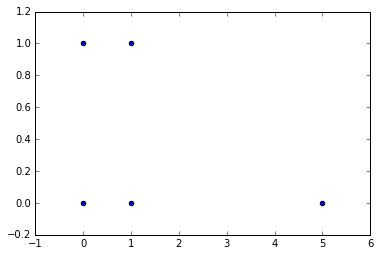

In [2]:
x = np.squeeze(np.asarray(instance[:,0]))
y = np.squeeze(np.asarray(instance[:,1]))
plt.cla()
plt.figure(1)
plt.scatter(x,y)
plt.show()

局部异常因子计算出每个点的局部密度，通过它与K最近邻的点的距离来评估点的局部密度，并与邻居的密度进行比较，以此找出异常点--异常点比邻居的密度要低得多

为了理解LOF,先了解一些术语的定义
* 对象P的K距离：对象P与它第K个最近邻的距离，K是算法的参数  
* P的K距离邻居：到P的距离小于或等于P到第K个最邻近的距离的所有对象的集合Q
* 从P到Q的可达距离：P与它的第K个最近邻的距离和P和Q之间的距离中的最大者。  
* P的局部可达密度（local Reachability Density of P）：K距离邻居和K与其邻居的可达距离之和的比值  
* P的局部异常因子（Local Outlier Factor of P):P与它的K最近邻的局部可达性的比值的平均值

In [4]:
# 获取点两两之间的距离pairwise_distance
distance = 'manhattan'
from sklearn.metrics import pairwise_distances
dist = pairwise_distances(instance,metric=distance)

In [5]:
print dist

[[ 0.  1.  2.  1.  5.]
 [ 1.  0.  1.  2.  6.]
 [ 2.  1.  0.  1.  5.]
 [ 1.  2.  1.  0.  4.]
 [ 5.  6.  5.  4.  0.]]


In [6]:
# 计算K距离，使用heapq来获得K最近邻
k = 2
# 计算K距离
import heapq
# k_distance的值是tuple
k_distance = defaultdict(tuple)
# 对每个点计算
for i in range(instance.shape[0]):
    # 获取它与所有其点之间的距离
    distances = dist[i].tolist()
    # 获得K最近邻
    ksmallest = heapq.nsmallest(k+1,distances)[1:][k-1]
    # 获取索引号
    ksmallest_idx = distances.index(ksmallest)
    # 记录下每个点到第K个最近邻以及到它的距离
    k_distance[i]=(ksmallest,ksmallest_idx)

In [7]:
# 计算K距离邻居
def all_indices(value,inlist):
    out_indices = []
    idx = -1
    while True:
        try:
            idx = inlist.index(value,idx+1)
            out_indices.append(idx)
        except ValueError:
            break
    return out_indices

In [9]:
# 计算K距离邻居
k_distance_neig = defaultdict(list)
for i in range(instance.shape[0]):
    # 获得它到所有邻居点的距离
    distances = dist[i].tolist()
    print 'k distance neighbourhood',i
    print distances
    # 获得从第1到第k的最近邻
    ksmallest = heapq.nsmallest(k+1,distances)[1:]
    print ksmallest
    ksmallest_set = set(ksmallest)
    print ksmallest_set
    ksmallest_idx = []
    # 获取k里最小的元素的索引号
    for x in ksmallest_set:
        ksmallest_idx.append(all_indices(x,distances))
    # 将列表的列表转换为列表
    ksmallest_idx = [item for sublist in ksmallest_idx for item in sublist]
    # 对每个点保存
    k_distance_neig[i].extend(zip(ksmallest,ksmallest_idx))

k distance neighbourhood 0
[0.0, 1.0, 2.0, 1.0, 5.0]
[1.0, 1.0]
set([1.0])
k distance neighbourhood 1
[1.0, 0.0, 1.0, 2.0, 6.0]
[1.0, 1.0]
set([1.0])
k distance neighbourhood 2
[2.0, 1.0, 0.0, 1.0, 5.0]
[1.0, 1.0]
set([1.0])
k distance neighbourhood 3
[1.0, 2.0, 1.0, 0.0, 4.0]
[1.0, 1.0]
set([1.0])
k distance neighbourhood 4
[5.0, 6.0, 5.0, 4.0, 0.0]
[4.0, 5.0]
set([4.0, 5.0])


In [10]:
print k_distance_neig

defaultdict(<type 'list'>, {0: [(1.0, 1), (1.0, 3)], 1: [(1.0, 0), (1.0, 2)], 2: [(1.0, 1), (1.0, 3)], 3: [(1.0, 0), (1.0, 2)], 4: [(4.0, 3), (5.0, 0)]})


In [11]:
# 计算可达距离和LRD
# 局部可达密度
local_reach_density = defaultdict(float)
for i in range(instance.shape[0]):
    # LRD分子，k距离邻居的个数
    no_neighbours = len(k_distance_neig[i])
    denom_sum = 0
    # 可达距离求和
    for neigh in k_distance_neig[i]:
        denom_sum += max(k_distance[neigh[1]][0],neigh[0])
    local_reach_density[i] = no_neighbours/(1.0*denom_sum)

In [12]:
# 计算LOF
lof_list = []
for i in range(instance.shape[0]):
    lrd_sum = 0
    rdist_sum = 0
    for neigh in k_distance_neig[i]:
        lrd_sum +=local_reach_density[neigh[1]]
        rdist_sum += max(k_distance[neigh[1]][0],neigh[0])
    lof_list.append((i,lrd_sum*rdist_sum))
print lof_list

[(0, 4.0), (1, 4.0), (2, 4.0), (3, 4.0), (4, 18.0)]


一个点的LOF很高，则认为它是一个异常点